# Розрахунки до праці

## Загальні функції

 - функції для росту
 - візуалізація

In [15]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def plot(fig, ax, model, figsize = [40, 40]):

    ax.set_aspect('equal')

    plt.rcParams['figure.figsize'] = figsize
    
    ax.cla()
    
    for river_pr in model.rivers:
        x = ([v.x for v in river_pr.data().vertices])
        y = ([v.y for v in river_pr.data().vertices])
        ax.plot(x, y)

    xmin = 0
    xmax = 0
    ymin = 0
    ymax = 0
    for boundary_pr in model.region:
        x = ([v.x for v in boundary_pr.data().vertices])
        y = ([v.y for v in boundary_pr.data().vertices])
        x.append(boundary_pr.data().vertices[0].x)
        y.append(boundary_pr.data().vertices[0].y)
        if min(x) < xmin:
            xmin = min(x)
        if max(x) > xmax:
            xmax = max(x)
        if min(y) < ymin:
            ymin = min(y)
        if max(y) > ymax:
            ymax = max(y)
        ax.plot(x, y)

    ax.set_xlim(xmin - 0.1, xmax + 0.1)
    ax.set_ylim(ymin - 0.1, ymax + 0.1)
    #plt.xlim(xmin - 0.1, xmax + 0.1)
    #plt.ylim(ymin - 0.1, ymax + 0.1)
    #plt.show()
    display(fig)
    clear_output(wait = True)
    #plt.pause(0.001)

In [14]:
def growRiver(m):

    solver = riversim.Solver(m.solver_params, verbose=False)
    triangle = riversim.Triangle(m.mesh_params)
    mesh = riversim.TethexMesh()

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    dynamic_river_ids = m.rivers.tipBranchesIds()

    for i in range(m.number_of_steps):
        # boundary generation: Combines boundary and river 
        # geometry into one(or several) closed boundary lines
        m.boundary = riversim.BoundaryGenerator(\
            m.sources, \
            m.region, \
            m.rivers, \
            m.river_width, \
            m.mesh_params.smoothness_degree, \
            m.mesh_params.ignored_smoothness_length)
    
        # mesh will be refined aroud growing tip points
        tip_points = riversim.t_PointList()
        for id in dynamic_river_ids:
            tip_points.append(m.rivers[id].tipPoint())
        triangle.mesh_params.tip_points = tip_points
        mesh = triangle.generate(m.boundary, m.region.holes)
    
        # reset solver values
        # solver.clear() lets try without it
        solver.openMesh(mesh)
    
        for j in range(m.solver_params.adaptive_refinment_steps + 1):
            if j > 0:
                solver.refineGrid()
            solver.setupSystem()
            solver.assembleSystem(m.boundary_conditions)
            solver.solve()
    
        #series parameters evaluation
        id_series_params = riversim.t_ids_series_params()
        max_a1 = 0
        for id in dynamic_river_ids:
            tip_point = m.rivers[id].tipPoint()
            tip_angle = m.rivers[id].tipAngle()
            id_series_params[id] = solver.integrate_new(m.integr_params, tip_point, tip_angle)
            if id_series_params[id][0] > max_a1:
                max_a1 = id_series_params[id][0]
    
        for id_series_param in id_series_params:
            id = id_series_param.key()
            series_param = id_series_param.data()
            if m.qGrowth(series_param):
                l = m.rivers[id].lenght()
                if m.qBifurcate(series_param, l):
                    tip_point = m.rivers[id].tipPoint()
                    tip_angle = m.rivers[id].tipAngle()
                    br_left = riversim.Branch(tip_point, tip_angle + m.bifurcation_angle)
                    br_left.addPoint(riversim.Polar(m.ds, 0), m.river_boundary_id)
                    br_right = riversim.Branch(tip_point, tip_angle - m.bifurcation_angle)
                    br_right.addPoint(riversim.Polar(m.ds, 0), m.river_boundary_id)
                    ids = m.rivers.addSubBranches(id, br_left, br_right)

                    # add new branches
                    dynamic_river_ids.append(ids.left)
                    dynamic_river_ids.append(ids.right)
                    
                    # and remove parent from growth evaluation
                    for f in range(len(dynamic_river_ids)):
                        if dynamic_river_ids[f] == id:
                            del dynamic_river_ids[f]
                            break
                else: 
                    m.rivers[id].addPoint(\
                        m.nextPoint(series_param, l, max_a1),\
                        m.river_boundary_id)
            else:
                # remove river from growth evaluation
                for f in range(len(dynamic_river_ids)):
                    if dynamic_river_ids[f] == id:
                        del dynamic_river_ids[f]
                        break
        
        plot(fig, ax, m)
        print(i)

        # nothing to grow
        if not dynamic_river_ids:
            break

## Розрахунки

Прикладове дерево котре генерувалося 8 годин

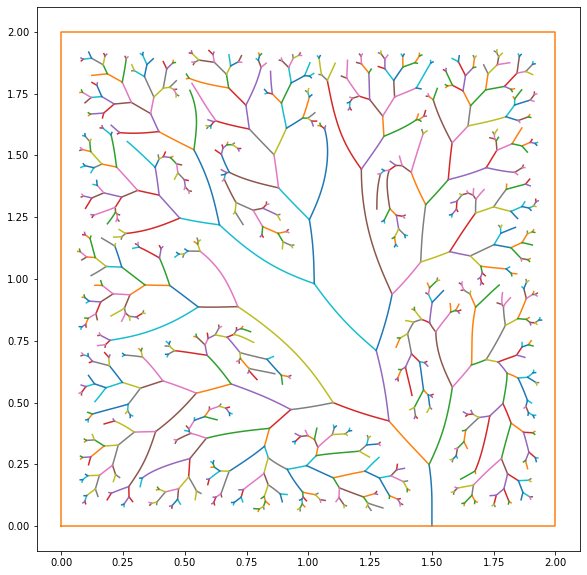

In [66]:
import riversim

model = riversim.Model()
riversim.open(model, "8h_model.json")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot(fig, ax, model, [15, 15])

### Гістограми

#### Функції для обчислення гістограми

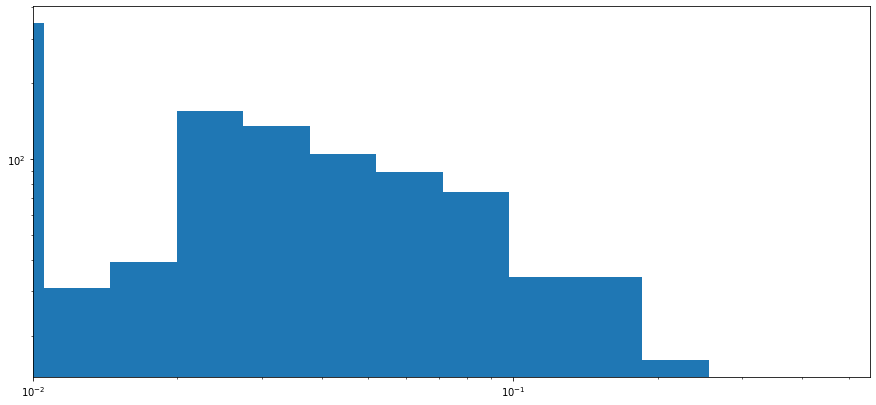

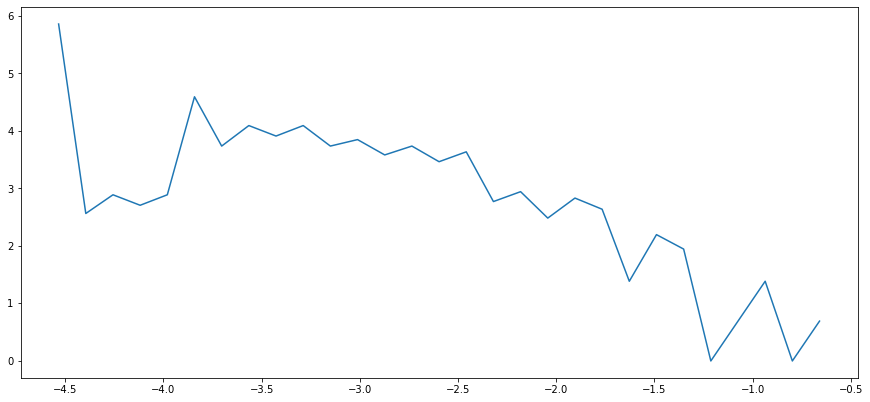

In [78]:
import numpy as np

def histogram_simple(rivers, n_bins = 30):
    lenghts = [riv_p.data().lenght() for riv_p in model.rivers]
    bins_arr = np.logspace(np.log10(min(lenghts)), np.log10(max(lenghts)), n_bins)
    [hist, bin_edges] = np.histogram(lenghts, bins = bins_arr)
    bin_edges_mid_points = (bin_edges[0:-1] + bin_edges[1:]) / 2.
    return hist, bin_edges_mid_points

lenghts = [riv_p.data().lenght() for riv_p in model.rivers]
bins_arr = np.logspace(np.log(min(lenghts)), np.log(max(lenghts)), 30)
plt.subplot(2, 1, 1)
plt.hist(lenghts, log = True, bins = bins_arr)
plt.xscale('log')
plt.xlim(min(lenghts), max(lenghts))
plt.show()

[hist, bins_mid_poinst] = histogram_simple(model.rivers, n_bins = 30)
plt.subplot(2, 1, 2)
plt.plot(np.log(bins_mid_poinst), np.log(hist))

In [76]:
np.logspace(np.log10(100000), np.log10(1), 10)

array([1.00000000e+05, 2.78255940e+04, 7.74263683e+03, 2.15443469e+03,
       5.99484250e+02, 1.66810054e+02, 4.64158883e+01, 1.29154967e+01,
       3.59381366e+00, 1.00000000e+00])

#### Звичайне правило росту

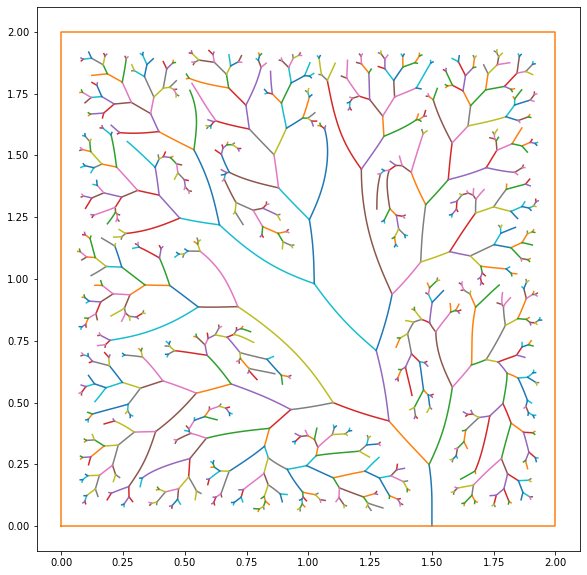

#### Правило взросту із імовірністю

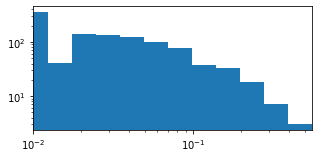

/tmp/ipykernel_91626/3810738809.py:14: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.exp(np.log((bin_edges[0:-1] + bin_edges[1:])/2.)), np.log(hist))


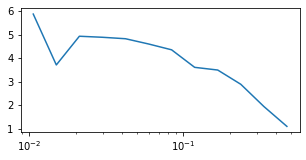

In [48]:
print((bin_edges[0:-1] + bin_edges[1:])/2.)
print(hist)

[0.03713568 0.09140704 0.1456784  0.19994976 0.25422113 0.30849249
 0.36276385 0.41703521 0.47130657 0.52557793]
[869 124  42  11  15   3   4   0   1   2]


(0.009999999999999882, 0.5527136129471161)

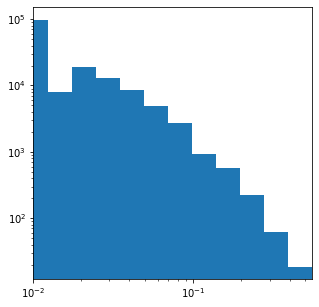

In [63]:
widths = (bins_arr[1:] - bins_arr[:-1])
bins_arr_mid = (bins_arr[1:] + bins_arr[:-1]) / 2.
hist = np.histogram(lenghts, bins=bins_arr)
hist_norm = hist[0] / widths


plt.bar(bins_arr_mid, hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.xlim(min(lenghts), max(lenghts))

In [4]:
m = riversim.Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.01
m.ds = 0.02
m.growth_threshold = 0.03 #blocks growing when a1 < 0.1 it also 
#has impact on performance
m.height = 2
m.width = 2
m.dx = 1.5
m.number_of_steps = 150

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeDirichlet()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(riversim.Polar(0.1, 0), m.river_boundary_id)

#river_solver = riversim.RiverSolver(m, prog_opt)
##river_solver.run()

118


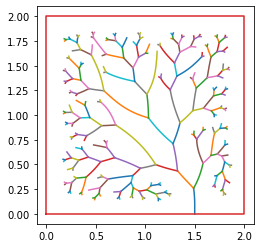

In [5]:
# you can specify some small number_of_steps(10-20) and 
# run this command several times, it will continue from prev state
growRiver(m)

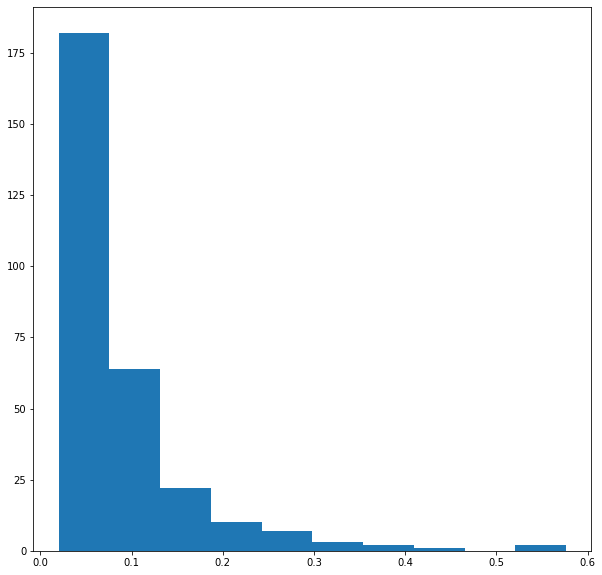

In [6]:
lenghts = [riv_p.data().lenght() for riv_p in m.rivers]
plt.hist(lenghts)
plt.show()
    

In [24]:
m = riversim.Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.03
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
#has impact on performance
m.height = 1
m.width = 1
m.dx = 0.75
m.number_of_steps = 20

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(riversim.Polar(0.1, 0), m.river_boundary_id)

19


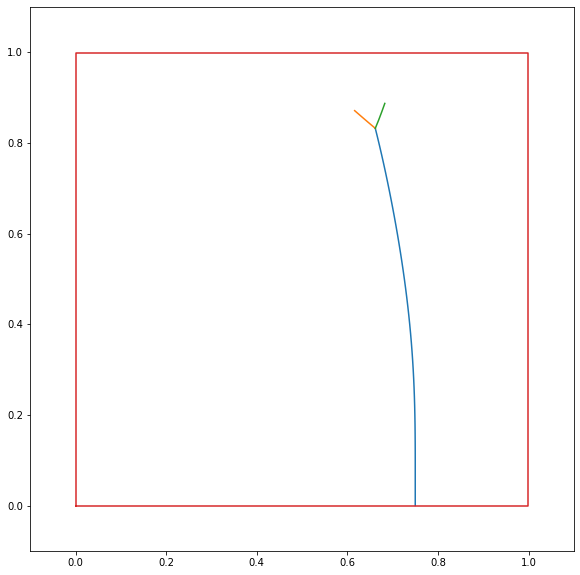

In [28]:
growRiver(m)

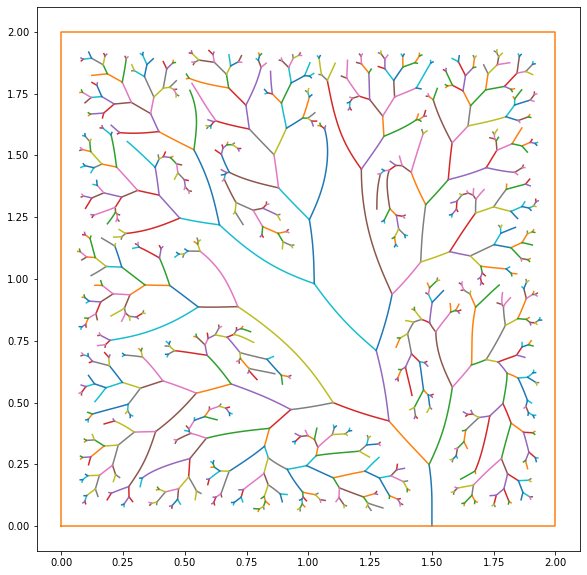

In [17]:
riversim.save(m, "8h_model")
m_in = riversim.Model()
riversim.open(m_in, "8h_model.json")
m == m_in
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot(fig, ax, m_in)

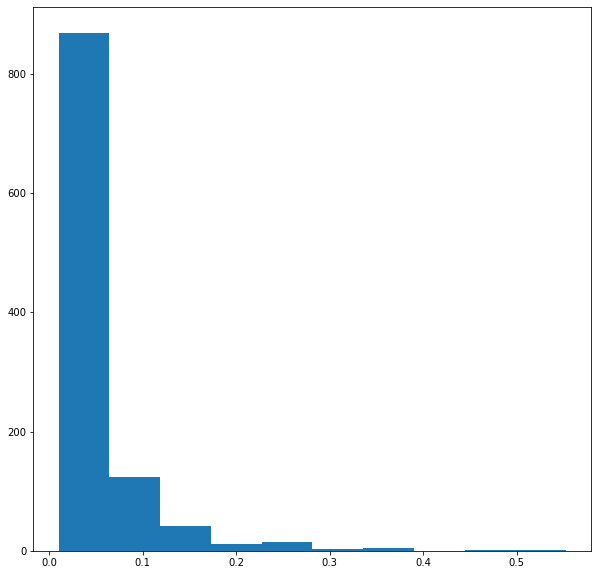

In [11]:
lenghts = [riv_p.data().lenght() for riv_p in m.rivers]
plt.hist(lenghts)
plt.show()

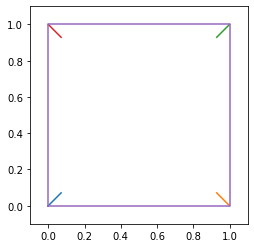

In [4]:
from riversim import Point, Line

m = riversim.Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = 0.5
m.bifurcation_min_dist = 0.01
m.ds = 0.02
m.growth_threshold = 0.01 #blocks growing when a1 < 0.1 it also 
#has impact on performance
m.number_of_steps = 30

m.solver_params.field_value = 1

boundary = riversim.Boundary()
boundary.vertices.extend([Point(0, 0), Point(1, 0), Point(1, 1), Point(0, 1)])
boundary.lines.extend([Line(0, 1, m.river_boundary_id), \
    Line(1, 2, m.river_boundary_id), \
    Line(2, 3, m.river_boundary_id), \
    Line(3, 0, m.river_boundary_id)])

m.region[1] = boundary

m.boundary_conditions[m.river_boundary_id] = riversim.BoundaryCondition()

source_1 = riversim.t_source_coord()
source_1.boundary_id = 1
source_1.vert_pos = 0
m.sources[1] = source_1
source_2 = riversim.t_source_coord()
source_2.boundary_id = 1
source_2.vert_pos = 1
m.sources[2] = source_2
source_3 = riversim.t_source_coord()
source_3.boundary_id = 1
source_3.vert_pos = 2
m.sources[3] = source_3
source_4 = riversim.t_source_coord()
source_4.boundary_id = 1
source_4.vert_pos = 3
m.sources[4] = source_4

m.rivers.initialize(m.region.getSourcesIdsPointsAndAngles(m.sources))

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(riversim.Polar(0.1, 0), m.river_boundary_id)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot(fig, ax, m)

29


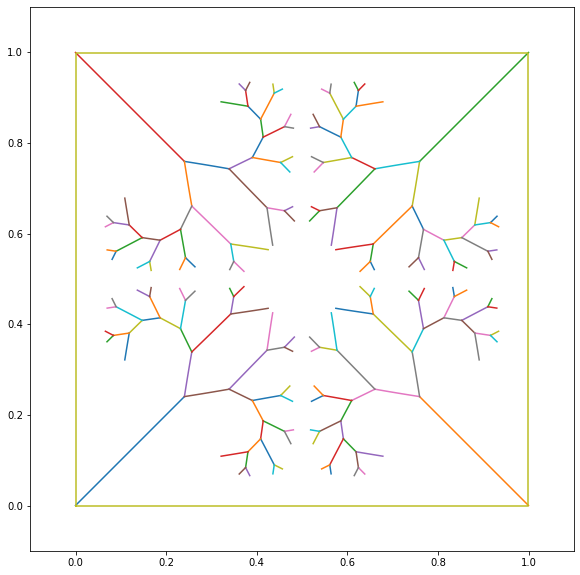

In [5]:
growRiver(m)

In [50]:
m = riversim.Model()
m.bifurcation_type = 1 # b3/b1
m.bifurcation_threshold = -10
m.bifurcation_min_dist = 0.01
m.ds = 0.02
m.growth_threshold = 0.03 #blocks growing when a1 < 0.1 it also 
#has impact on performance
m.height = 7
m.width = 2
m.dx = 1.5
m.number_of_steps = 150

# initialziation of initial state
# this function does a lot of configuration work. Determines geometry, 
# boundary conditions, points were river should grow and holes in geometry.
# This can be done also manually
m.initializeLaplace()

# grow each river for length of 0.1 to avoid circular integaration aroud 
# tips in empty area(outside of region)
for source_id in m.sources.getSourcesIds():
    m.rivers[source_id].addPoint(riversim.Polar(0.1, 0), m.river_boundary_id)

149


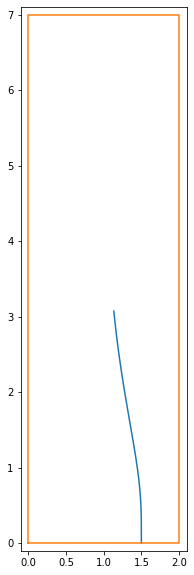

In [51]:
growRiver(m)